<a href="https://colab.research.google.com/github/acp1997/rl-journey/blob/main/01_Dual_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [ ]:
# install this for box2d
!pip install swig
# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.*

In [2]:
import numpy as np
import random
import gym
import collections
import tensorflow as tf
import tensorflow.keras as tfk
from IPython import display
import matplotlib.pyplot as plt
import pickle

In [20]:
from google.colab import drive
drive.mount('/gdrive')

In [4]:
!rm -r 'sample_data'

# Atari Environment

In [5]:
env = gym.make('LunarLander-v2')
_ = env.seed(44)

print(env.observation_space)
print(env.action_space)

Box(-inf, inf, (8,), float32)
Discrete(4)


# Agent, Memory & EpsilonSchedulers

In [6]:
class DQNAgent:
    def __init__(self, model):

        # create and sync target model
        self.online_model = self.create_online_model(model)
        self.target_model = self.create_target_model(self.online_model)
        self.sync_models()

        # create trainable model
        self.trainable_model = self.create_trainable_model(self.online_model)

        return

    def create_trainable_model(self, model):
        states = model.inputs[0]
        qvalues = model.outputs[0]
        actions = tfk.layers.Input(shape=(1,), dtype='int32')
        masked_qvalues = tf.gather(qvalues, actions, axis=1, batch_dims=1)
        trainable_model = tfk.Model(inputs = [states, actions], outputs=[masked_qvalues])

        trainable_model.summary()
        trainable_model.compile(tfk.optimizers.Adam(learning_rate=0.001), tfk.losses.MeanSquaredError(), [tfk.metrics.MeanSquaredError()])
        return trainable_model

    def create_online_model(self, model):
        return tfk.models.clone_model(model)

    def create_target_model(self, model):
        return tfk.models.clone_model(model)

    def sync_models(self, alpha=1):
        target_weights = []
        for w1, w2 in zip(self.online_model.get_weights(), self.target_model.get_weights()):
            target_weights.append(alpha*w1 + (1-alpha)*w2)

        self.target_model.set_weights(target_weights)
        return

    def predict(self, inp):
        return self.online_model(inp)

    def predict_target(self, inp):
        return self.target_model(inp)

    def batch_predict_target(self, inp):
        return self.target_model.predict(inp, verbose=0)

    def fit(self, states, actions, target_qvaluess, **kwargs):
        _ = self.trainable_model.fit(
            x=[states, actions],
            y=[target_qvaluess],
            **kwargs
        )
        return

    def choose_best_action(self, qvalues):
        return np.argmax(qvalues)

    def choose_random_action(self, qvalues):
        return random.randint(0, len(qvalues)-1)

    def choose_epsgreedy_action(self, qvalues, eps):
        p = random.random()
        if p < eps:
            return self.choose_random_action(qvalues)
        else:
            return self.choose_best_action(qvalues)


def linear_decay_scheduler(nth_step, start_value, end_value, steps):
    delta = (start_value - end_value)/steps
    return max(end_value, start_value - delta*nth_step)

def power_decay_scheduler(nth_step, start_value, end_value, decay_factor):
    return max(start_value*decay_factor**nth_step, end_value)

def step_decay_scheduler(nth_step, start_value, end_value, decay_steps, decay_factor):
    return max(end_value, start_value - (nth_step//decay_steps)*decay_factor)


class Memory:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = collections.deque()
        return

    def size(self):
        return len(self.buffer)

    def isfull(self):
        return len(self.buffer)>=self.buffer_size

    def store(self, element):
        if self.isfull():
            self.buffer.popleft()
        self.buffer.append(element)
        return

    def sample(self, sample_size):
        sample_size = min(sample_size, self.size())

        elements = random.sample(self.buffer, sample_size)
        states = np.array([e[0] for e in elements])
        actions = np.array([e[1] for e in elements])
        next_states = np.array([e[2] for e in elements])
        rewards = np.array([e[3] for e in elements])
        dones = np.array([e[4] for e in elements])
        return states, actions, next_states, rewards, dones


class Logger():
    def __init__(self):
        self.x, self.y = [], []
        return

    def add_point(self, x, y):
        self.x.append(x)
        self.y.append(y)
        return

    def start_live_plot(self):
        self.fig, self.ax = plt.subplots(1,1)
        self.hdisplay = display.display("", display_id=True)
        self.curve = self.ax.plot(self.x,self.y)[0]
        return

    def refresh_live_plot(self):
        self.curve.set_xdata(self.x)
        self.curve.set_ydata(self.y)
        self.ax.relim()
        self.ax.autoscale()
        self.hdisplay.update(self.fig)
        return

    def get_avg_value(self, lookback=None):
        if lookback:
            lookback = min(lookback,len(self.y))
        else:
            lookback = len(self.y)
        return sum(self.y[-1:-lookback-1:-1])/lookback



# Initialisation

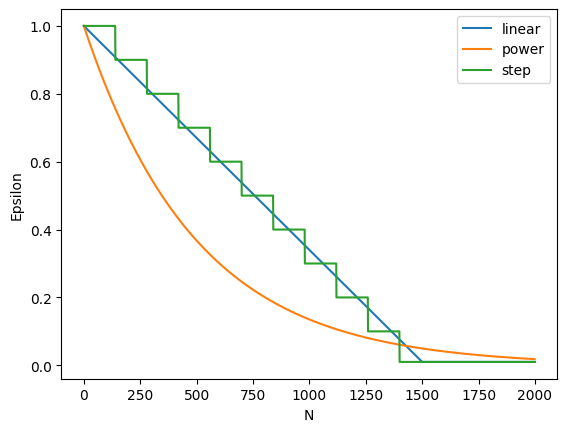

In [8]:
e1 = [linear_decay_scheduler(n, start_value=1.0, end_value=0.01, steps=1500) for n in range(2000)]
e2 = [power_decay_scheduler(n, start_value=1, end_value=0.01, decay_factor=0.998) for n in range(2000)]
e3 = [step_decay_scheduler(n, start_value=1, end_value=0.01, decay_steps=140, decay_factor=.1) for n in range(2000)]

plt.figure()
plt.xlabel('N')
plt.ylabel('Epsilon')
plt.plot(e1, label='linear')
plt.plot(e2, label='power')
plt.plot(e3, label='step')
plt.legend()
plt.show()

In [9]:
# define model here

def build_model():
    inp = tfk.layers.Input(shape=(8,))
    nn = inp

    nn = tfk.layers.Dense(128, activation='relu')(nn)
    nn = tfk.layers.Dense(128, activation='relu')(nn)
    nn = tfk.layers.Dense(128, activation='relu')(nn)
    nn = tfk.layers.Dense(128, activation='relu')(nn)

    out = tfk.layers.Dense(4, activation='linear')(nn)

    model = tfk.Model(inputs=[inp], outputs=[out])

    return model

# del model
# del build_model
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 128)               1152      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 4)                 516       
                                                                 
Total params: 51204 (200.02 KB)
Trainable params: 51204 (200.

In [10]:
agent = DQNAgent(model)

eps_decay = lambda n: power_decay_scheduler(n, start_value=1, end_value=0.01, decay_factor=0.998)

buffer_size = 10000
memory = Memory(buffer_size)

reward_log = Logger()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  1152      ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  16512     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 128)                  16512     ['dense_1[0][0]']             
                                                                                            

# Training Loop

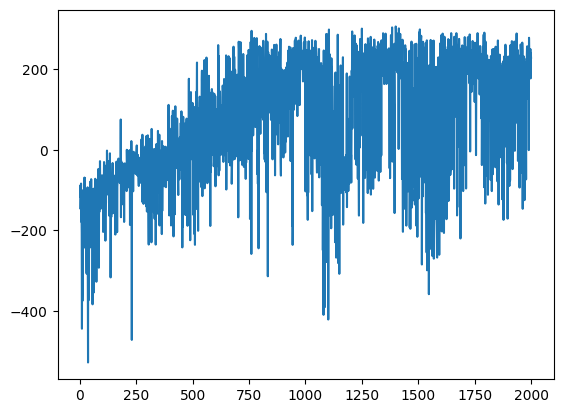

Avg Reward From Game 0 - 100 : -167.17197685457916
Avg Reward From Game 100 - 200 : -90.5830998669345
Avg Reward From Game 200 - 300 : -54.20323340063016
Avg Reward From Game 300 - 400 : -52.294375274259636
Avg Reward From Game 400 - 500 : -18.910954463588737
Avg Reward From Game 500 - 600 : 41.67567162899854
Avg Reward From Game 600 - 700 : 78.07753484196938
Avg Reward From Game 700 - 800 : 103.44194799156193
Avg Reward From Game 800 - 900 : 143.65165176265262
Avg Reward From Game 900 - 1000 : 179.09743099918768
Avg Reward From Game 1000 - 1100 : 103.57520865561288
Avg Reward From Game 1100 - 1200 : -21.681123958769913
Avg Reward From Game 1200 - 1300 : 143.9696092550262
Avg Reward From Game 1300 - 1400 : 191.8620692799676
Avg Reward From Game 1400 - 1500 : 81.70950364243815
Avg Reward From Game 1500 - 1600 : -9.76364575030401
Avg Reward From Game 1600 - 1700 : 108.24848314483462
Avg Reward From Game 1700 - 1800 : 197.31528923545545
Avg Reward From Game 1800 - 1900 : 138.2686385832163

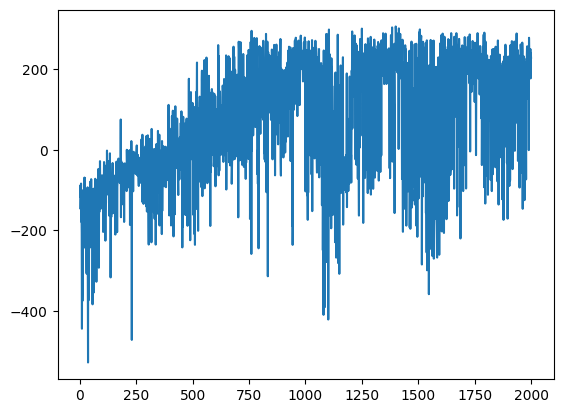

In [11]:
n_games=2000
batch_size = 32
epoch_size = 1024
min_samples_to_train = 2000
gamma = 0.99

train_after_n_games = 1
sync_after_n_updates = 10
soft_update_alpha=1

n_updates=0
reward_log.start_live_plot()

for nth_game in range(1,n_games+1):
    game_reward=0

    if (nth_game % train_after_n_games == 0) and (memory.size() >= min_samples_to_train):
        train=True
        n_updates+=1
    else:
        train=False

    if n_updates % sync_after_n_updates==0:
        sync_target=True
        n_updates=0
    else:
        sync_target=False
        # sync_target=True


    done=False
    state = env.reset()
    while not done:
        qvalues = agent.predict(np.array([state]))[0]
        eps = eps_decay(nth_game-1)
        action = agent.choose_epsgreedy_action(qvalues, eps)
        next_state, reward, done, info = env.step(action)
        memory.store((state, action, next_state, reward, done))
        state = next_state

        game_reward += reward


    if train:
        states, actions, next_states, rewards, dones = memory.sample(epoch_size)
        future_qvaluess = agent.batch_predict_target(next_states)
        target_qvaluess = np.where(
            dones==False,
            rewards + gamma*np.max(future_qvaluess,axis=1),
            rewards
            )

        agent.fit(states, actions.reshape(-1,1), target_qvaluess.reshape(-1,1), batch_size=batch_size, verbose=0)


    if sync_target:
        agent.sync_models(soft_update_alpha)


    reward_log.add_point(nth_game, game_reward)
    reward_log.refresh_live_plot()
    if nth_game%100 ==0:
        print(f"Avg Reward From Game {nth_game-100} - {nth_game} : {reward_log.get_avg_value(lookback=100)}")


# Save

In [16]:
artefacts = {}
artefacts['agent'] = agent
artefacts['rewards'] = reward_log.y
with open('01_dqn_artefacts.pkl','wb') as f:
    pickle.dump(artefacts,f)

In [19]:
!mkdir -p '/gdrive/MyDrive/temporary/rl'
!cp -a '01_dqn_artefacts.pkl' '/gdrive/MyDrive/temporary/rl/01_dqn_artefacts.pkl'

# End